


# **Pipeline de Dados do Telegram**

Por [Carlos Andrés Soto Espinosa]()



---



# **Tópicos**

<ol type="1">
  <li>Contexto;</li>
  <li>Ingestão;</li>
  <li>ETL;</li>
  <li>Apresentação;</li>
  <li>Storytelling.</li>
</ol>

---

# **1.Contexto:**

É muito comum hoje em dia automatizar varios serviços a través do uso de bots como os de atendimento ao cliente, aonde são feitas consultas, solicitações, confirmações, contratações de serviços, cancelamentos, etc.
Em vista disto, neste projeto contruí um pipeline completo de captação de dados mediante um bot e as conversas de um grupo de chat na Plataforma do Telegram. Utilizando algumas ferramentas da AWS para realizar a ingestão, preocesamento e analisis desses dados.  


**Arquitetura do projeto:**


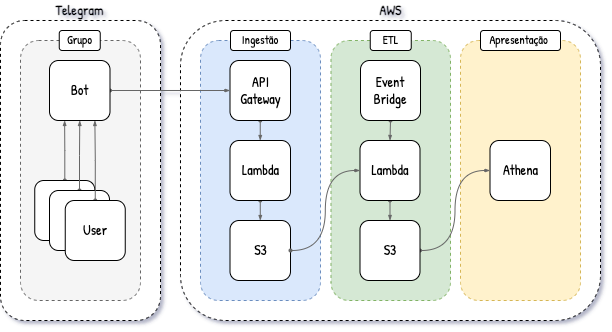

* **Telegram:** Aquí o Bot almacena os dados compartilhados pelos os usuários dentro do frupo de chat.
* **Ingestão (AWS):**
  * *API Gateway:* Permine a comunicação, com segurança, entre as Ferramentas AWS utilizadas e o Bot do Telegram.  
  * *Lambda:* Captura os dados em estado cru (raw).  
  * *S3:* Os dados são armazenados aquí num Bucket formato arquivo JSON.
* **ETL (AWS):**
  * *EventBridge:* Aquí é feita a arquitetura orientada a eventos a seguir.
  * *Lambda:* Obtém os dados crús os procesa e ordena de forma pronta pra consumo.
  * *S3:* Guardamos os dados num arquivo formato Parquet.
* **Apresentação:** consultas SQL e visualizações com Athena.

## 2\. Ingestão

2.1. Criação de um `bucket` no `AWS S3` para o armazenamento de dados crus, adicionando o sufixo `-raw`.

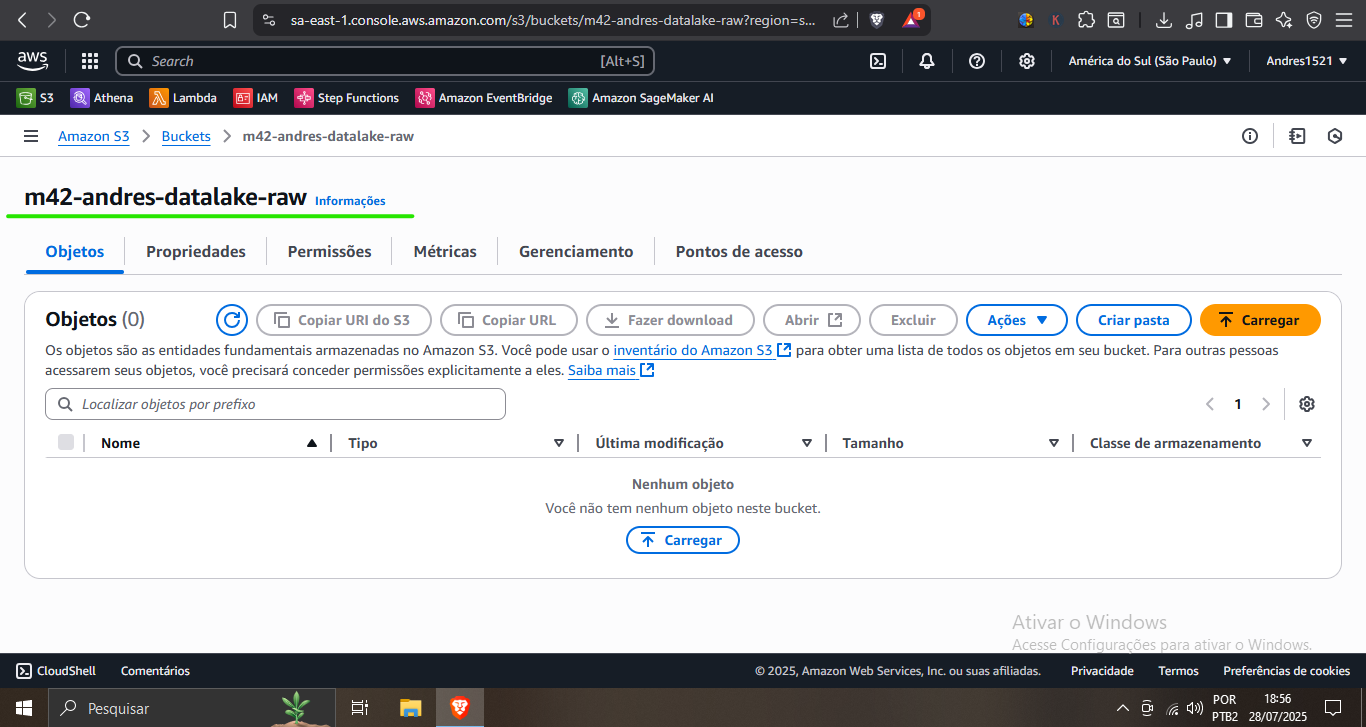

2.2. Criando uma função no `AWS Lambda` para recebimento das mensagens e armazenamento no formato JSON no `bucket` de dados crus. Configurando as variáveis de ambiente e adicionando os permissos de interação com `AWS S3` no `AWS IAM`.

> **Nota**: Para testar a função com evento do próprio `AWS Lambda`, substitua o código `message = json.loads(event["body"])` por `message = event`. Lembre-se que o primeiro só faz sentido na integração com o `AWS API Gateway`.

* Fazendo o deploy da função Lambda:

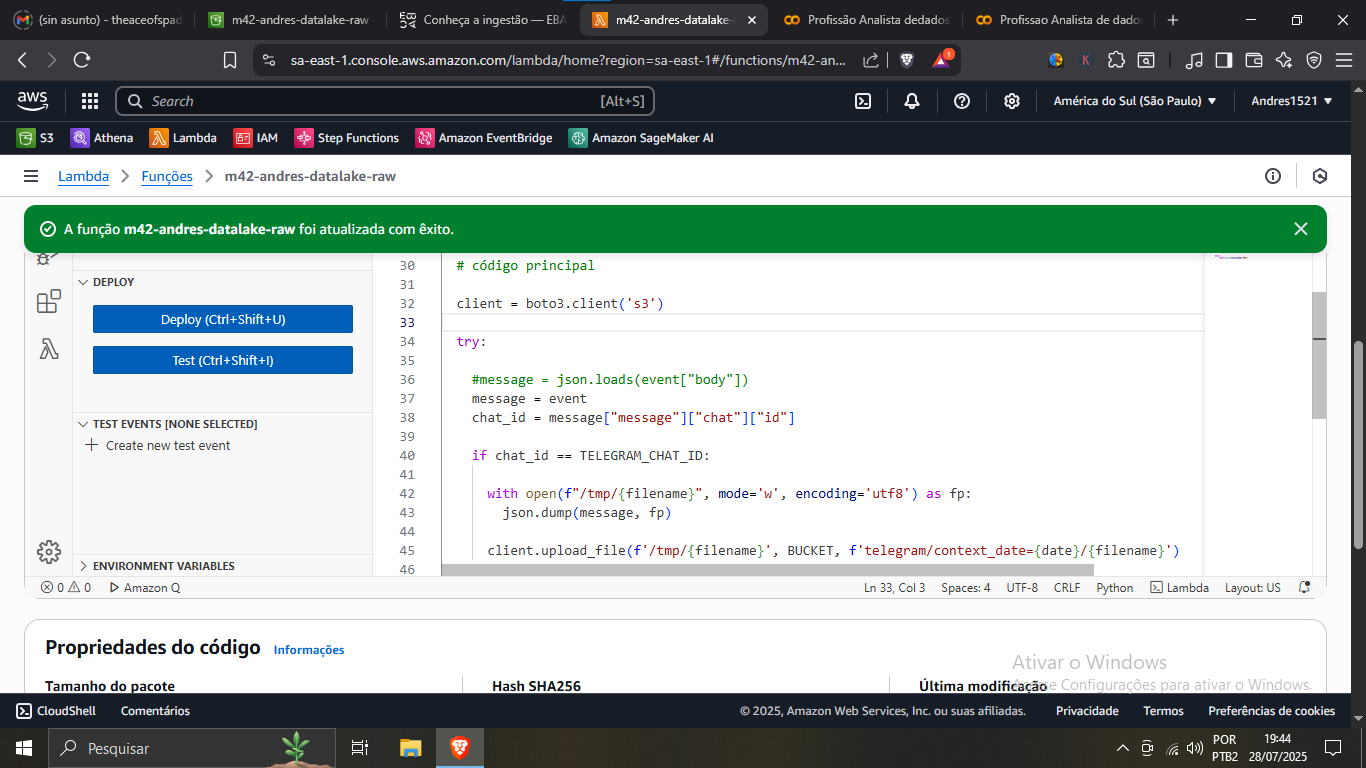

* Testando a Função:

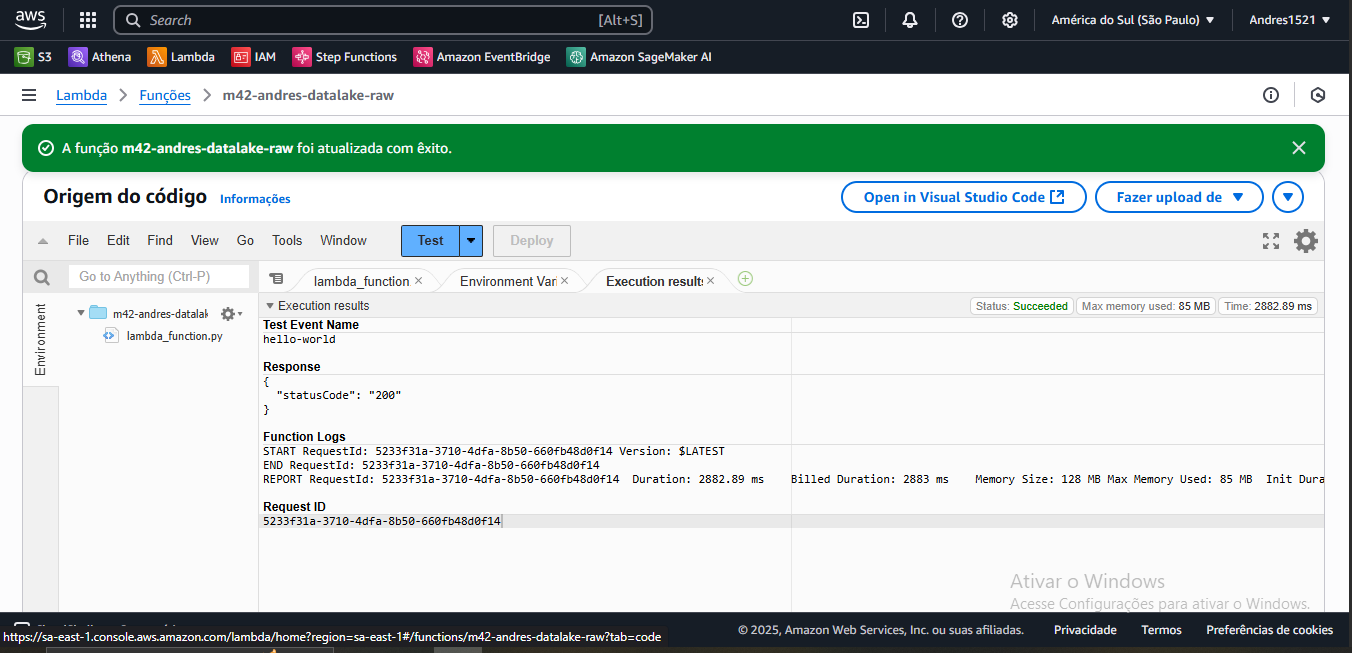

* Confirmando as pastas e arquivo Json no bucket 'm42-andres-datalake-raw' na S3:

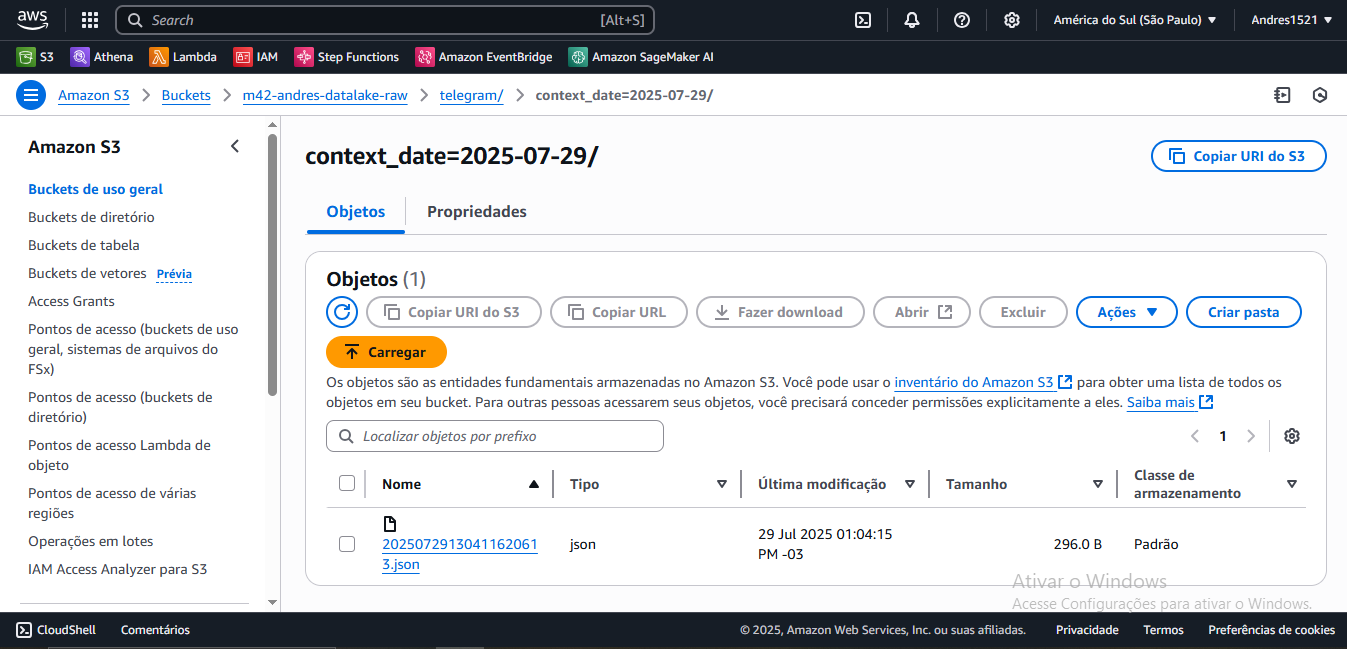

2.3. Criando uma API no `AWS API Gateway` a conectando a função do `AWS Lambda`.

> **Nota**: por motivos de segurança não disponibilizo o endereço da API gerada.

In [ ]:
from getpass import getpass

aws_api_gateway_url = getpass()

··········


2.4. Configurando o *webhook* do *bot* através do método `setWebhook` da API de *bots* do **Telegram**. Utilizando o endereço da API criada no `AWS API Gateway`. Com o método `getWebhookInfo` para consultar a integração.

> **Nota**: por motivos de segurança não disponibilizo o *token* de acesso ao *bot* da API de *bots* do **Telegram**.

In [ ]:
token = getpass()

··········


In [ ]:
import json

base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
import requests

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook was set"
}


In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://w8wn9ajb99.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 3,
    "max_connections": 40,
    "ip_address": "54.232.134.235"
  }
}


## 3\. ETL

3.1. Criando um `bucket` no `AWS S3` para o armazenamento de dados enriquecidos, adicionando o sufixo `-enriched` para diferenciar.

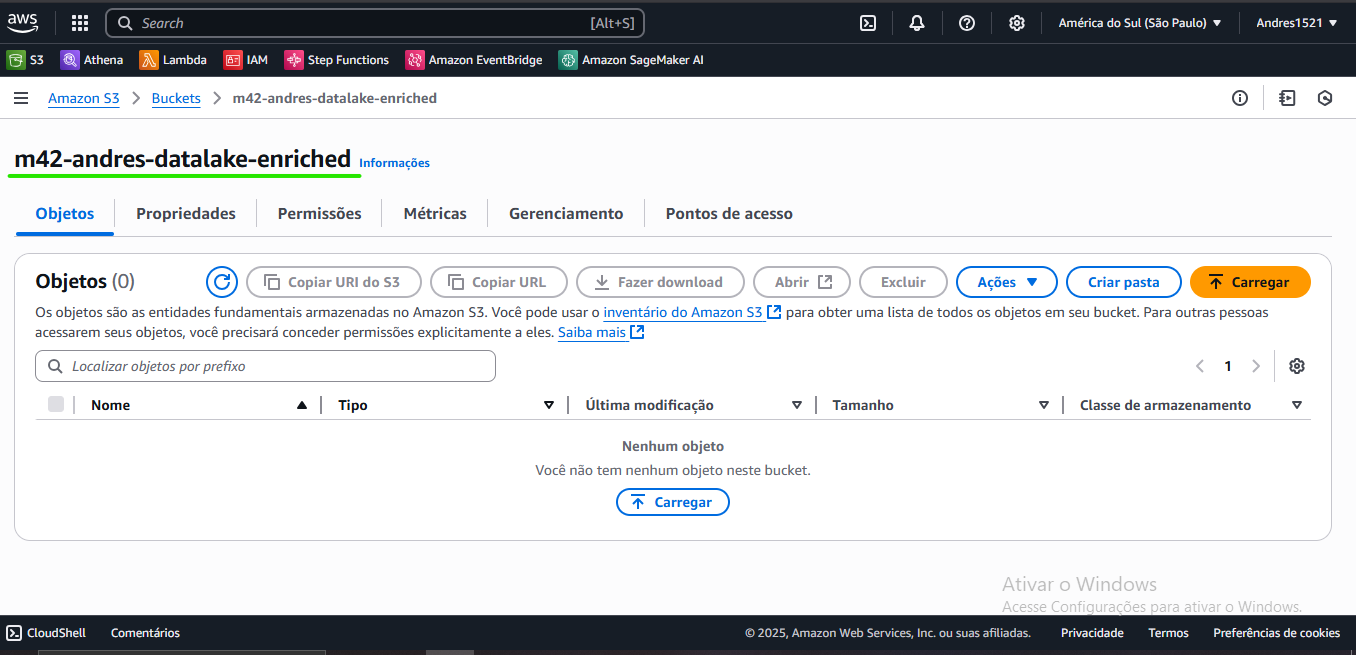

3.2. Criando uma função no `AWS Lambda` para processar as mensagens JSON de uma única partição do dia anterior (D-1), armazenadas no *bucket* de dados crus. Salvando o resultado em um único arquivo PARQUET, também particionado por dia. Configurando as variáveis de ambiente, adicionando permissão de interação com `AWS S3` no `AWS IAM`, configurando o *timeout* e de adicionar a *layer* com o código do pacote Python PyArrow.

> **Nota**: Para testar a função, substitúo o código  `date =  (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')` por  `date = (datetime.now(tzinfo) -timedelta(days=0)).strftime('%Y-%m-%d')`, permitindo assim o processamento de mensagens de um mesmo dia.

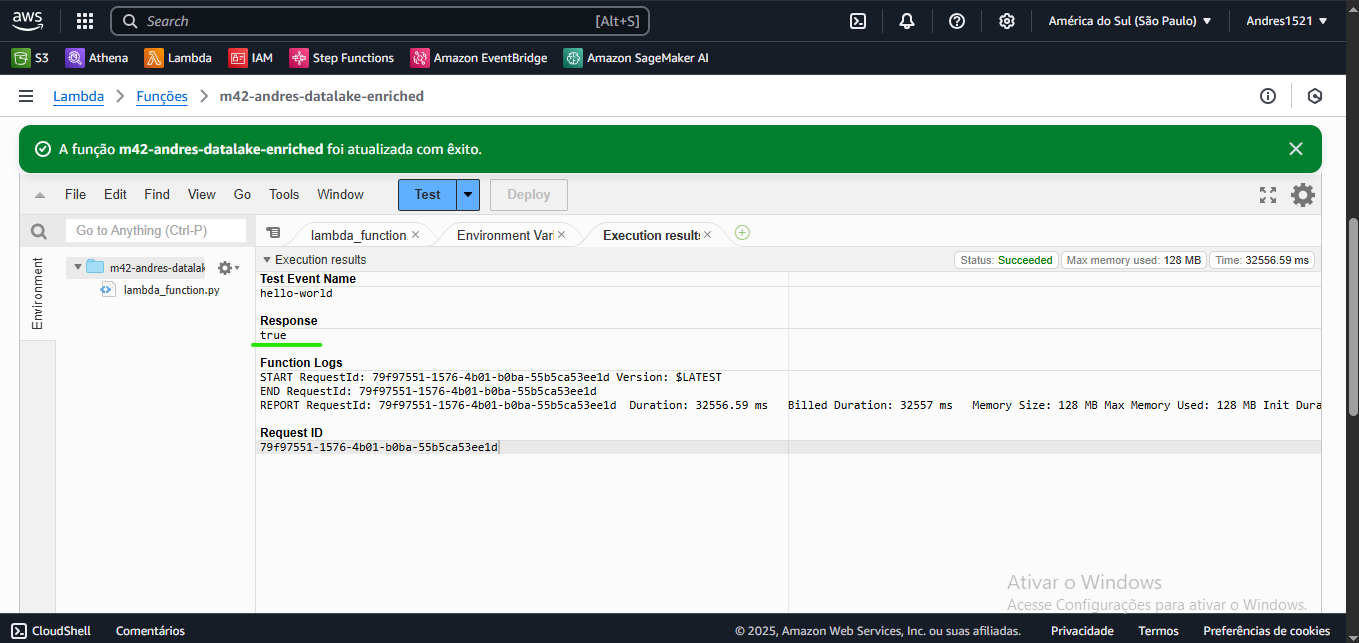

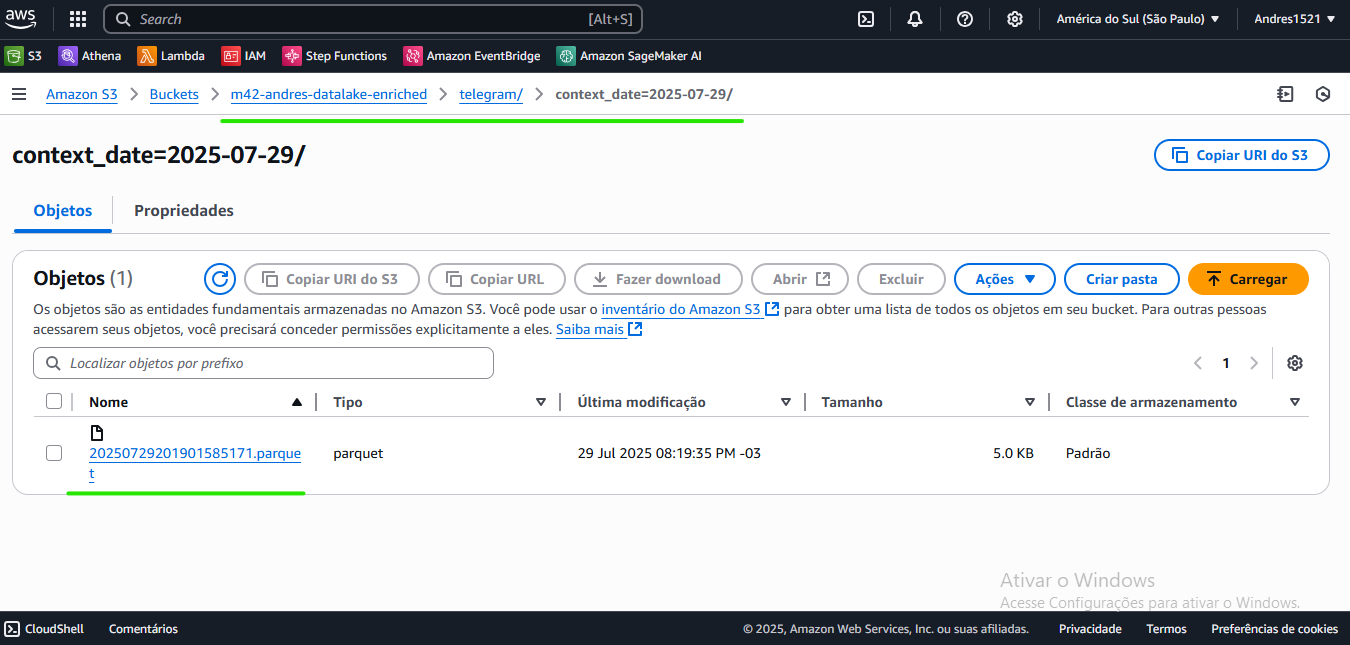

3.3. Criando uma regra no `AWS Event Bridge` para executar a função do `AWS Lambda` todo dia a meia noite no horário de Brasília (GMT-3).

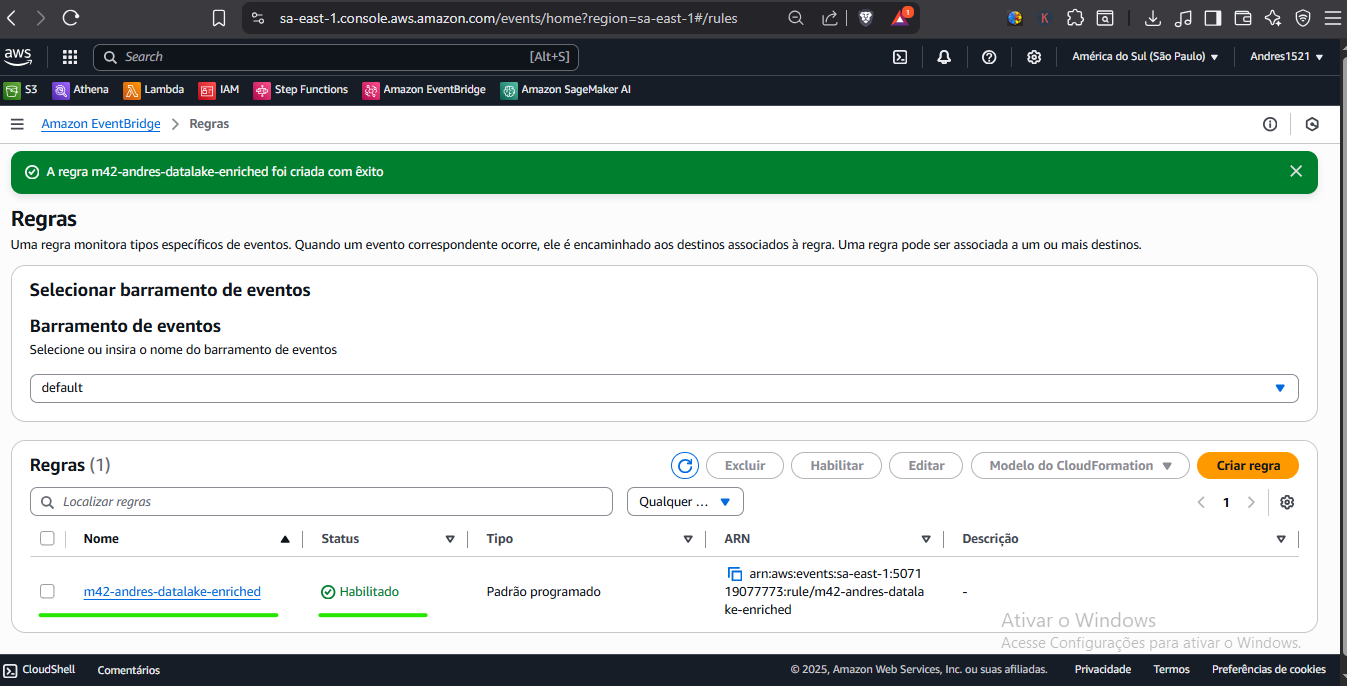

## 4\. Apresentação

4.1. Criando uma tabela no `AWS Athena` que aponta para os dados armazenados no bucket enriquecido do `AWS S3`.

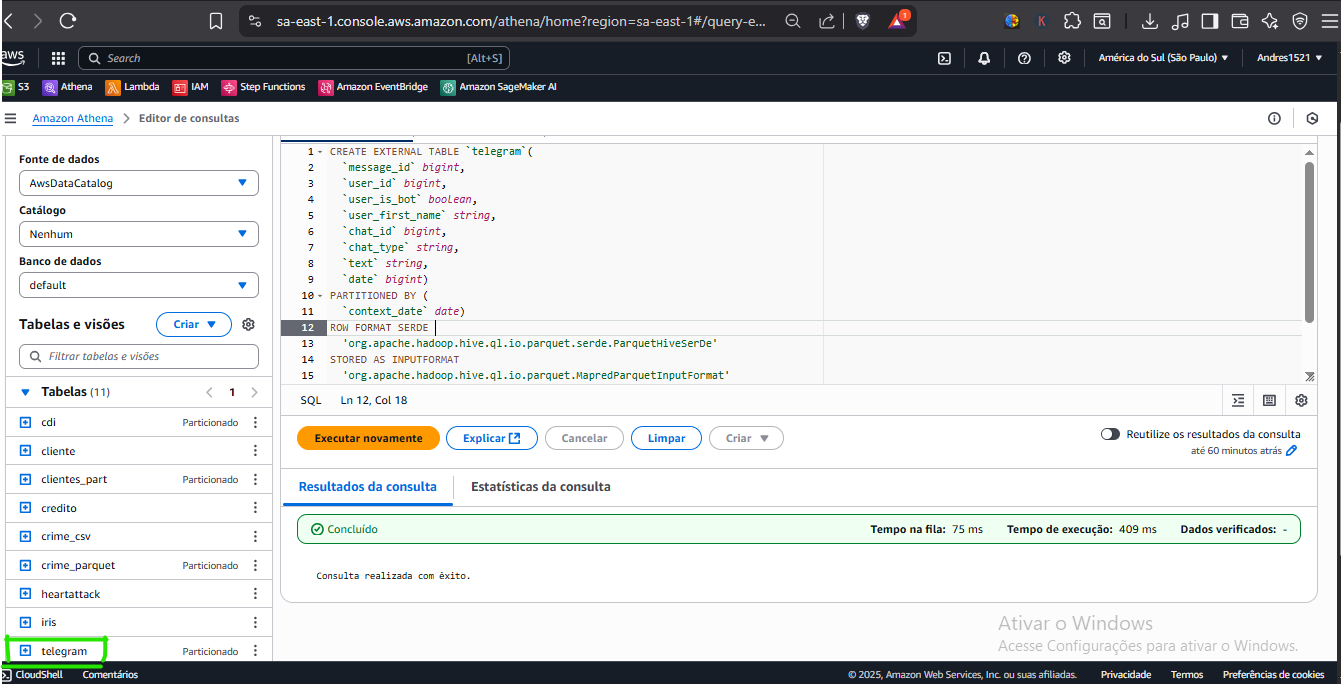

4.2. Executando o comando `MSCK REPAIR TABLE <nome-tabela>` para carregar as partições.

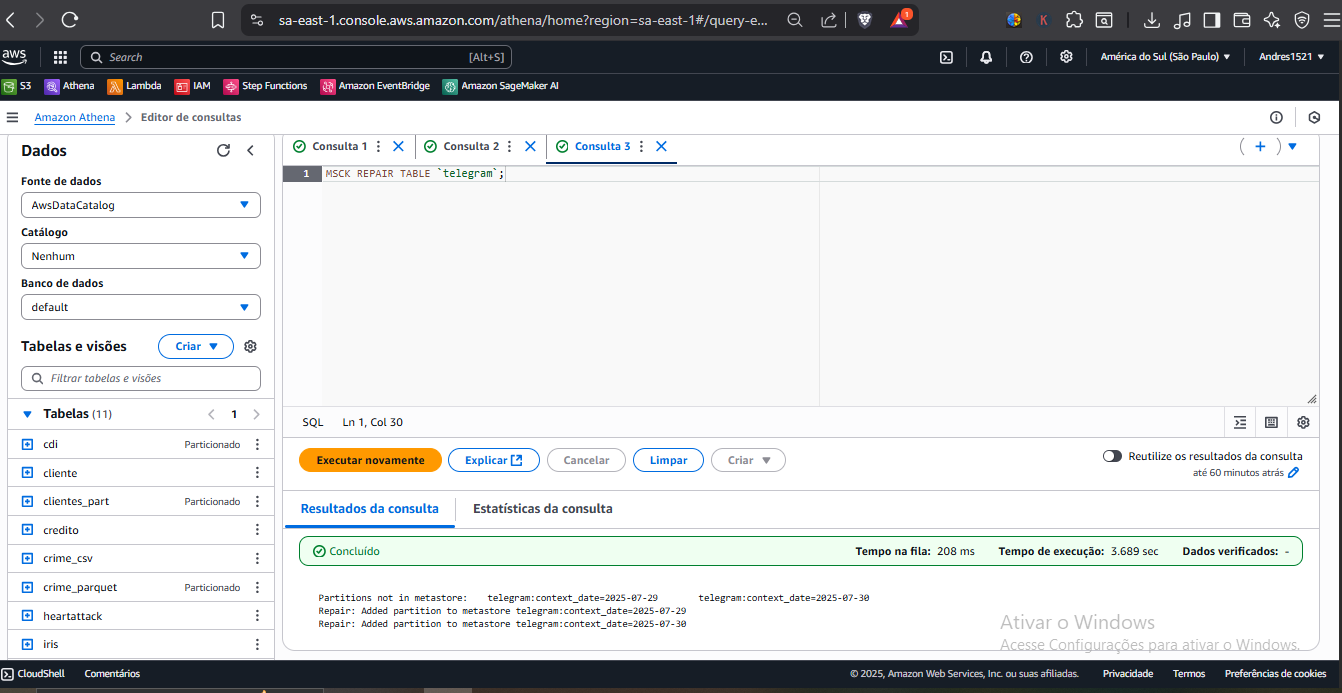

4.3. Executo as consultas SQL para explorar os dados.

- Média do tamanho das mensagens por usuário por dia:

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

Resultado:


> Para o dia 2025-07-30 vemos que a mensagen média tem 233 caracteres.
E 208 para o dia 2025-07-29.



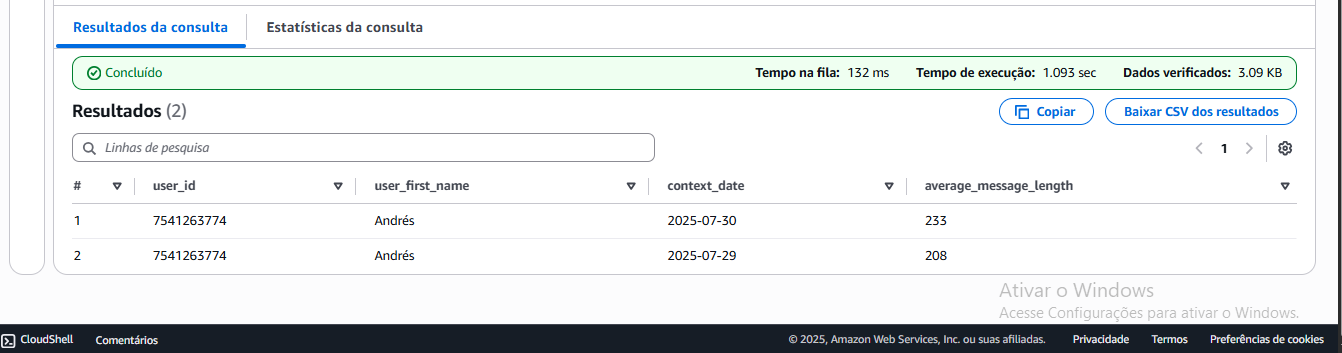

- Quantidade de mensagens por hora por dia da semana por número da semana:

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

Resultado:


> Aquí podemos ver que ás 21hs da seegunda-feira (parsed_date_weekly = 1), da semana 31 do ano foram enviadas 8 mensagens no grupo.

> E ás 20hs de quarta-feira também da semana 31 do mês foram enviadas 2 mensagens.




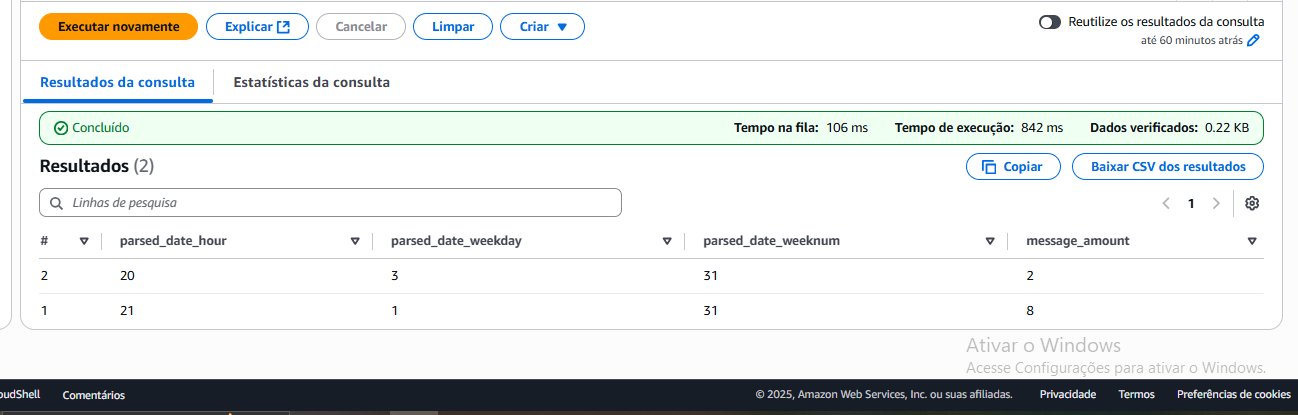

*  Mensagens que contém a palavra clave específica "viajar" ou "Viajar"

```sql
SELECT user_first_name, text, date
FROM "default"."telegram"
WHERE text LIKE '%viajar%' OR text LIKE '%Viajar%'
ORDER BY date DESC;
```

Resultado:


> Aqui podemos ver que a palavra "viajar" esteve presente em 5 mensagens enviadas no grupo, o que pode servir como um indicador de demanda e/ou interesse por parte dos integrantes.



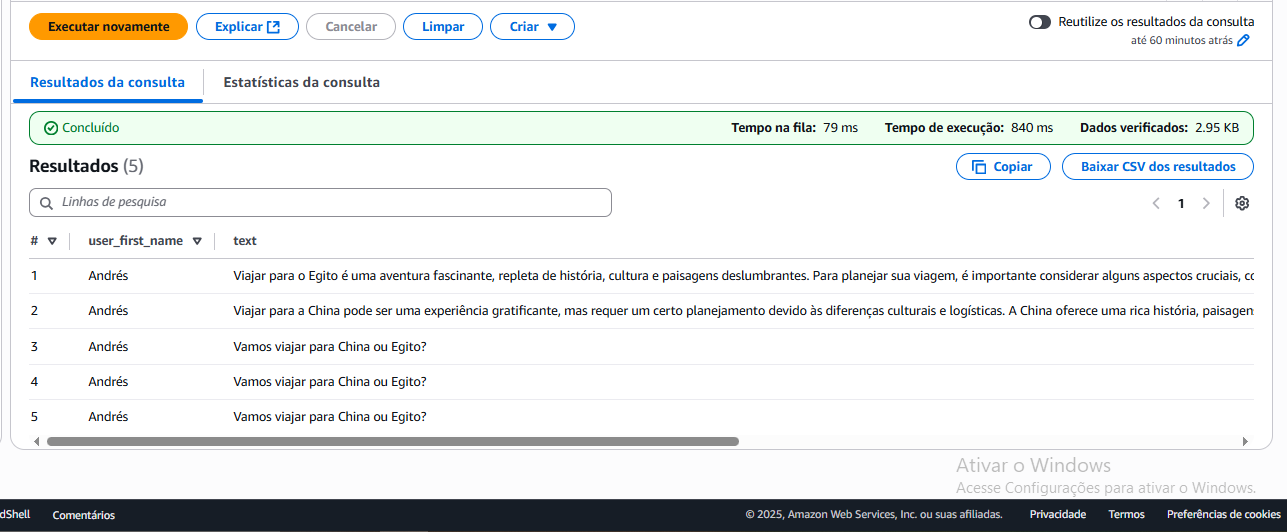

## 5\. Storytelling

Neste projeto, podemos ver como é possível usar ferramentas, como os da AWS, mas tem outras também, para criar um fluxo de dados completo, passando por suas etapas que ainda deixam margens enormes para melhorar. Desde as mensagens de um bot no Telegram até a análise com SQL e visualizações.

Com esse pipeline, conseguimos exemplificar e transformar dados brutos no formato JSON em informações úteis, com um potencial enorme, como:

* Quais usuários são os que mais participam;

* Quais palavras mais aparecem nas conversas, melhor identificando interesses;

* Qué dias e horários em que o grupo é mais movimentado.

A Idéia por trás desse projeto, além de articular e consolidar o conhecimento, é ajudar a entender e estimular a criação de mais ideias e projetos relacionados. Além de mostrar o potencial e escalabilidade de um trabalho assim, que gera insights poderosos que entregam resultados diretos a través da melhor toma de desições e planejamento.
